In [1]:
import os
import torch
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import scipy
import torch
from torch.utils.data import DataLoader

os.chdir('..')
from data_processing.datasets import PigletDataset2
from neuralnet.model import SpectraMLP
import data_processing.preprocessing as preprocessing
from config import left_cut, right_cut
from torch.utils.data import ConcatDataset
import utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1. Convert into pigdiff form
2. Feed it into neural network to predict


In [2]:
path_to_data = './dataset/simulated-Piglet-Data'
img = scipy.io.loadmat('./dataset/simulated-Piglet-Data/185_185_121_1/hypercube_baseline.mat')
img2 = scipy.io.loadmat('./dataset/miniCYRIL-Piglet-Data/LWP512/LWP512_Ws_31Jul_2017_17  16.mat')
img3 = scipy.io.loadmat('./data_simulations/out_SBV.mat')
img.keys() 
# img['hypercube'].shape

# ppl_2, ppl_1, ppl, hypercube

dict_keys(['__header__', '__version__', '__globals__', 'hypercube'])

### Prediction on absolute spectral value

Read simulated dataset into dictionary

In [3]:
path = "dataset/simulated-Piglet-Data/"
folder = os.listdir(path)
folder = [i for i in folder if i != '.DS_Store']
dic = {}
for i in folder:    
    files = os.listdir(path+i)
    files = [i for i in files if ".mat" in i]
    if files == []: continue
    dic[i] = files
    
print(dic)

{'185_185_121_1': ['PPLvessel_baseline.mat', 'PPLgrey_hypoxia.mat', 'PPLvessel_hypoxia.mat', 'PPLtot_baseline.mat', 'PPLtot_hypoxia.mat', 'PPLgrey_baseline.mat', 'hypercube_baseline.mat', 'hypercube_hypoxia.mat'], '185_185_121_2': ['PPLvessel_baseline.mat', 'PPLgrey_hypoxia.mat', 'PPLvessel_hypoxia.mat', 'PPLtot_baseline.mat', 'PPLtot_hypoxia.mat', 'PPLgrey_baseline.mat', 'hypercube_baseline.mat', 'hypercube_hypoxia.mat']}


Create a spectra dataset similiar to that of piglet_diff that will be feed into the neural network

In [3]:
search_keys = ['ppl_2', 'ppl_1', 'ppl', 'hypercube']

for pig in dic.keys():
    for index, date in enumerate(dic[pig]):  
        img = scipy.io.loadmat(path+ pig + '/' + date)
        matching_keys = [key for key in img.keys() if any(search_key in key for search_key in search_keys)][0]
        spectr = img[matching_keys]
        
        # to get the form of the piglet dataset
        spectr = spectr.reshape((-1, spectr.shape[-1]))
        num_wavelengths, num_spect = spectr.shape
        cut = 1000
        
        #ref spectrum (Relative concentration prediction, for later)
        ref_spectr = spectr[:, 0]
        
        spectra_list = []
        coef_list = [] # Not really needed, just to match the parameters of Pigletdataset
        
        # Alternatively set cut if don't want to use all spectral info
        for i in tqdm(range(0, num_spect)):
            spect = spectr[:, i]
            spectra_list.append(spect)
        
        # Save files
        utils.save_optimization_data2(ref_spectr, spectra_list, coef_list, str(pig)+'_'+str(date))
           

100%|██████████████████████████████████████| 121/121 [00:00<00:00, 40439.11it/s]


Feed to neural network

In [2]:
path_to_data = "dataset/piglet_diffs_sim1/"
spectra_dataset = PigletDataset2(path_to_data)
n = 15
spectra_datasets = ConcatDataset(n * [spectra_dataset])
dl = DataLoader(spectra_datasets, batch_size=n*7830, shuffle=False)
inputs  = next(iter(dl))

model = SpectraMLP(4)
#checkpoints = torch.load('model_checkpoints/best_model.pth')
checkpoints = torch.load('results_v2/4_256/best_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoints)
model.to(device)
model.eval()

/Users/boeykaizhe/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


SpectraMLP(
  (layers): ModuleList(
    (0): LazyLinear(in_features=0, out_features=1024, bias=True)
    (1): ELU(alpha=1.0)
    (2): LazyLinear(in_features=0, out_features=1024, bias=True)
    (3): ELU(alpha=1.0)
    (4): LazyLinear(in_features=0, out_features=1024, bias=True)
    (5): ELU(alpha=1.0)
    (6): LazyLinear(in_features=0, out_features=1024, bias=True)
    (7): ELU(alpha=1.0)
    (8): LazyLinear(in_features=0, out_features=4, bias=True)
  )
)

(117450, 4)


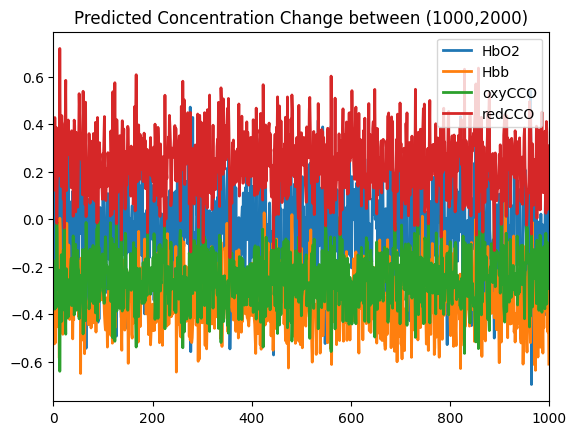

In [3]:
# Prediction on the absolute spectral value
preds = model(inputs.float()).detach().numpy()
print(preds.shape)

lcut = 1000
rcut = 2000
cut = rcut-lcut
cut_preds = preds[lcut:rcut]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
coef = ["HbO2", "Hbb", "oxyCCO", "redCCO"]
for i in range(4):
    plt.plot(cut_preds[:, i], color=colors[i], label=coef[i], linewidth=2)

plt.title(f"Predicted Concentration Change between ({lcut},{rcut})")
plt.xlim([0, cut])
plt.legend()

### Prediction on relative spectral value

Create a spectra dataset similiar to that of piglet_diff that will be feed into the neural network

In [9]:
search_keys = ['ppl_2', 'ppl_1', 'ppl', 'hypercube']

for pig in dic.keys():
    for index, date in enumerate(dic[pig]):  
        img = scipy.io.loadmat(path+ pig + '/' + date)
        matching_keys = [key for key in img.keys() if any(search_key in key for search_key in search_keys)][0]
        spectr = img[matching_keys]
        
        # to get the form of the piglet dataset
        spectr = spectr.reshape((-1, spectr.shape[-1]))
        num_wavelengths, num_spect = spectr.shape
        cut = 1000
        
         #ref spectrum (Relative concentration prediction, for later)
        ref_spectr = spectr[:, 0]
        
        spectra_list = []
        coef_list = [] # Not really needed, just to match the parameters of Pigletdataset
        
        # Alternatively set cut if don't want to use all spectral info
        for i in tqdm(range(0, num_spect)):
            spect = spectr[:, i] / ref_spectr
            spectra_list.append(spect)
        
        # Save files
        utils.save_optimization_data2(ref_spectr, spectra_list, coef_list, str(pig)+'_'+str(date))
      

  0%|                                                   | 0/121 [00:00<?, ?it/s]/var/folders/pb/tb9th22s1bg2w5j250zz59s80000gn/T/ipykernel_19113/901933302.py:22: RuntimeWarning: invalid value encountered in divide
  spect = spectr[:, i] / ref_spectr
/var/folders/pb/tb9th22s1bg2w5j250zz59s80000gn/T/ipykernel_19113/901933302.py:22: RuntimeWarning: divide by zero encountered in divide
  spect = spectr[:, i] / ref_spectr
100%|███████████████████████████████████████| 121/121 [00:00<00:00, 1083.58it/s]


Make prediction on relative spectral data

In [7]:
path_to_data = "dataset/piglet_diffs_sim2/"
spectra_dataset = PigletDataset2(path_to_data)
n = 15
spectra_datasets = ConcatDataset(n * [spectra_dataset])
dl = DataLoader(spectra_datasets, batch_size=n*7830, shuffle=False)
inputs  = next(iter(dl))

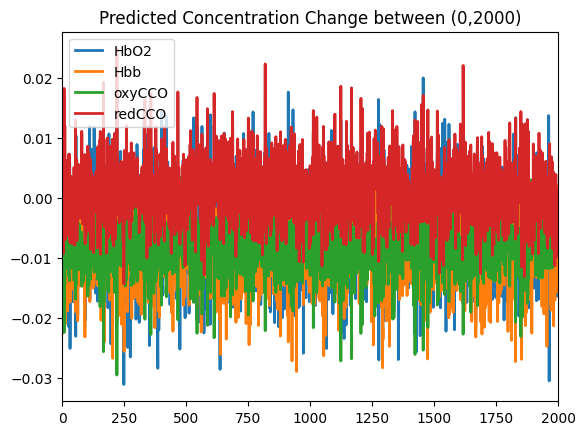

In [8]:
# Prediction on the absolute spectral value
preds = model(inputs.float()).detach().numpy()

lcut = 0
rcut = 2000
cut = rcut-lcut
cut_preds = preds[lcut:rcut]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
coef = ["HbO2", "Hbb", "oxyCCO", "redCCO"]
for i in range(4):
    plt.plot(cut_preds[:, i], color=colors[i], label=coef[i], linewidth=2)

plt.title(f"Predicted Concentration Change between ({lcut},{rcut})")
plt.xlim([0, cut])
plt.legend()